Import Libraries and Data

In [120]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import logsumexp
data = np.loadtxt('binarydigits.txt')

Define Functions

In [ ]:
def param_init(K, X): # Initialise parameters
    """
    K   : scalar representing number of mixtures
    X   : NxD matrix of data points
    pi  : 1xK vector of mixture fractions
    P   : KxD matrix of parameters
    """
    _, D = X.shape
    pi = np.ones(K)/K               # Uniform
    P = np.random.rand(K, D)        # Random
    P = np.clip(P, 1e-10, 1-1e-10)  # Clipped to avoid log(0)
    return pi, P

def calc_log_likelihood(pi, P, X): # Compute Log Likelihood
    """
    pi      : 1xK vector of mixture fractions
    P       : KxD matrix of parameters
    X       : NxD matrix of data points
    l       : NxK matrix of log likelihood values
    """
    l = X@np.log(P).T + (1-X)@np.log(1-P).T
    return l

def update_log_r(pi, P, X): # Update responsibilities
    """
    pi      : 1xK vector of mixture fractions
    P       : KxD matrix of parameters
    X       : NxD matrix of data points
    r       : NxK matrix of responsibilities
    """
    log_likelihood = calc_log_likelihood(pi, P, X)
    log_prior = np.log(pi)[None, :]
    log_prob = log_likelihood + log_prior
    mixture_log_likelihood = logsumexp(log_prob, axis=1, keepdims=True)

    log_r = log_prob - mixture_log_likelihood
    total_log_likelihood = np.sum(mixture_log_likelihood)
    return log_r, total_log_likelihood

def update_P_d(r, X_d): # Update Bernoulli parameters
    """
    r       : NxK matrix of responsibilities   
    X_d     : Nx1 vector of Dth column of data points in X
    P_d     : Kx1 vector of Dth column of parameters in P
    """
    num = r.T@X_d
    den = np.sum(r, axis = 0)
    P_d = num/den
    return P_d


def update_pi(r, X): # Update mixture weights
    """
    r   : NxK matrix of responsibilities
    X   : NxD matrix of data points
    pi  : 1xK vector of mixture fractions
    """
    N, _ = X.shape
    pi = np.sum(r, axis=0)/N
    return pi


def e_step(pi, P, X): # Apply e step
    """
    pi      : 1xK vector of mixture fractions
    P       : KxD matrix of parameters
    X       : NxD matrix of data points
    r       : NxK matrix of responsibilities
    total_l : scalar value representing total mixture log likelihood
    """
    log_r, total_l = update_log_r(pi, P, X)
    r = np.exp(log_r)
    return r, total_l

 
def m_step(r, X): # Apply m step
    """
    r       : NxK matrix of responsibilities
    X       : NxD matrix of data points
    pi      : 1xK vector of mixture fractions
    P       : KxD matrix of parameters
    """
    pi = update_pi(r, X)
    _, D = X.shape
    _, K = r.shape
    P = np.zeros((K, D))
    for d in range(D):
        P[:, d] = update_P_d(r, X[:, d])
    P = np.clip(P, 1e-10, 1-1e-10)  # Clipped to avoid log(0)
    return pi, P


def em_run(K, X, max_iter=200, tol=1e-10): # Loop EM
    """
    K       : scalar representing number of mixtures
    X       : NxD matrix of data points
    pi      : 1xK vector of mixture fractions
    P       : KxD matrix of parameters
    r       : NxK matrix of responsibilities
    total_l : scalar value representing total mixture log likelihood
    i       : scalar representing number of completed iterations
    """
    pi, P = param_init(K, X)
    l_history = []
    delta = np.inf
    total_l_prev = -np.inf
    i = 0
    while i<max_iter and delta>tol:
        r, total_l = e_step(pi, P, X)
        pi, P = m_step(r, X)
        delta = total_l - total_l_prev
        l_history += [total_l]
        total_l_prev = total_l
        i += 1
    return pi, P, r, total_l, i, l_history


Run EM Loop and Create Plots

Number of Mixtures: 2
Iterations Completed: 16
Final Log Likelihood: -3303.5906123966843
Mixture weights: [0.41963514 0.58036486]

Number of Mixtures: 3
Iterations Completed: 13
Final Log Likelihood: -3090.5481478758948
Mixture weights: [0.63043133 0.20956867 0.16      ]

Number of Mixtures: 4
Iterations Completed: 12
Final Log Likelihood: -2882.841110030044
Mixture weights: [0.21001455 0.43000985 0.19998142 0.15999417]

Number of Mixtures: 7
Iterations Completed: 33
Final Log Likelihood: -2563.19473485729
Mixture weights: [0.15       0.26000043 0.15997343 0.16002767 0.1500012  0.04999888 0.0699984 ]

Number of Mixtures: 10
Iterations Completed: 14
Final Log Likelihood: -2295.557342508771
Mixture weights: [0.0499833  0.09000597 0.18       0.11997335 0.16004761 0.03       0.05999575 0.16       0.09999438 0.04999965]

Bits: [4767, 4459, 4160, 3698, 3312]


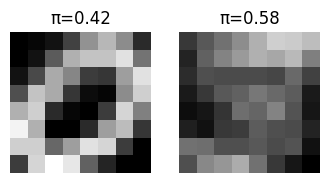

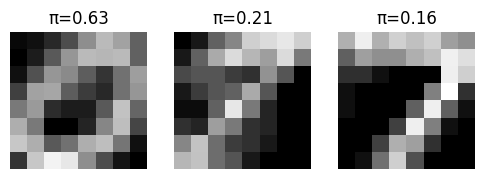

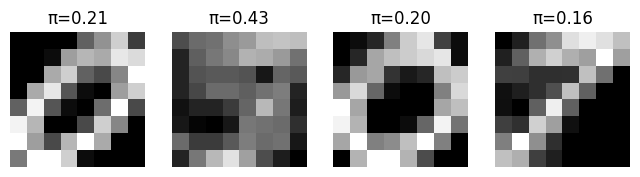

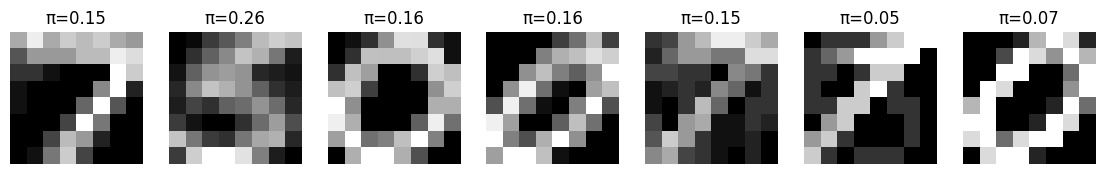

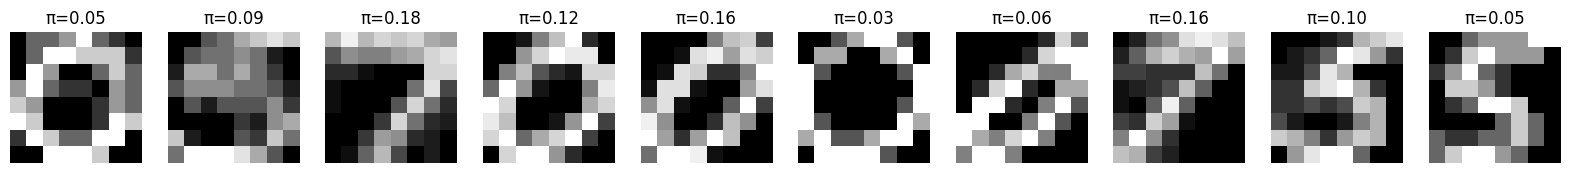

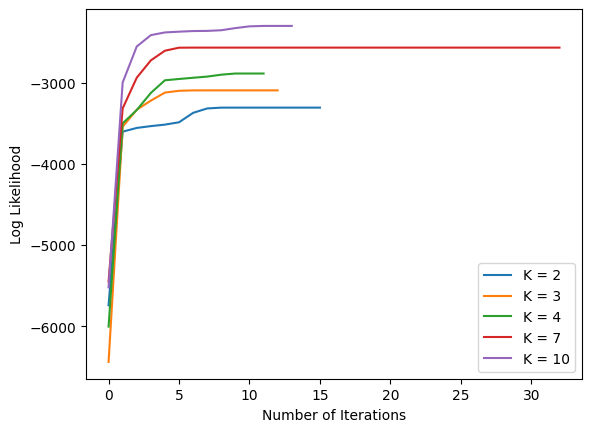

In [ ]:
# Run EM for each K and plot data
mixtures = [2, 3, 4, 7, 10]
bits = []
plt.figure(1)
for idxK, K in enumerate(mixtures):

    pi, P, r, log_likelihood, iteration, l_history = em_run(K, data)

    bits += [int(np.ceil(-log_likelihood/np.log(2)))]
    print('Number of Mixtures: ' + str(K))
    print('Iterations Completed:', iteration)
    print('Final Log Likelihood:', log_likelihood)
    print('Mixture weights:', pi)
    print("")

    plt.figure(idxK+2, figsize=(2*K, 3))
    for k in range(K):
        plt.subplot(1, K, k+1)
        plt.imshow(P[k].reshape(8,8), cmap='gray', vmin=0, vmax=1, interpolation='nearest')
        plt.title(f"π={pi[k]:.2f}")
        plt.axis('off')

    plt.figure(1)
    plt.plot(l_history, label='K = ' + str(K))
    plt.ylabel('Log Likelihood')
    plt.xlabel('Number of Iterations')
    plt.legend(loc = 'lower right')


print('Bits:', bits)

Run Repeated EM Loops and Create Plots

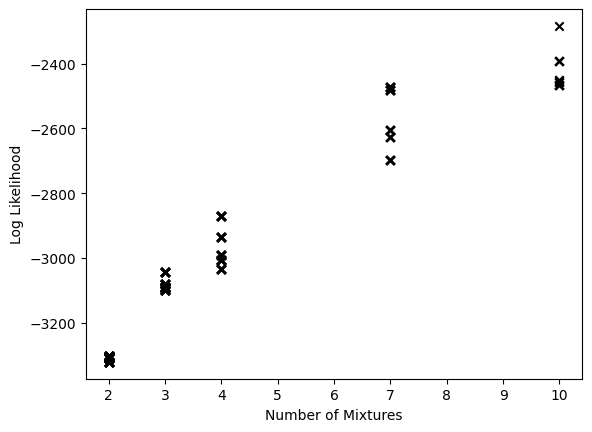

In [123]:
n_repeats = 5

ll_arr = []
K_arr = []
plt.figure()
for idxK, K in enumerate(mixtures):
    for repeat in range(n_repeats):
        pi, P, r, log_likelihood, iteration, l_history = em_run(K, data)
        ll_arr += [log_likelihood]
        K_arr += [K]
        plt.scatter(K_arr, ll_arr, marker='x', c='k')
        plt.ylabel('Log Likelihood')
        plt.xlabel('Number of Mixtures')

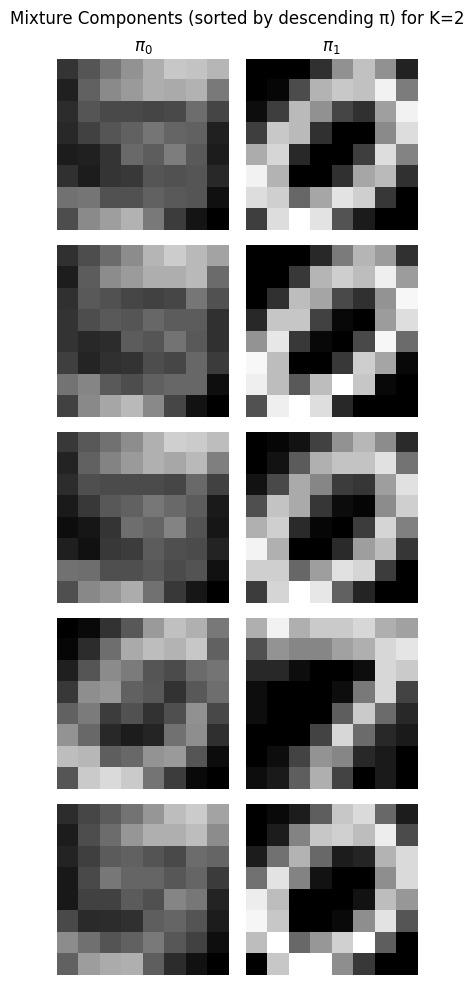

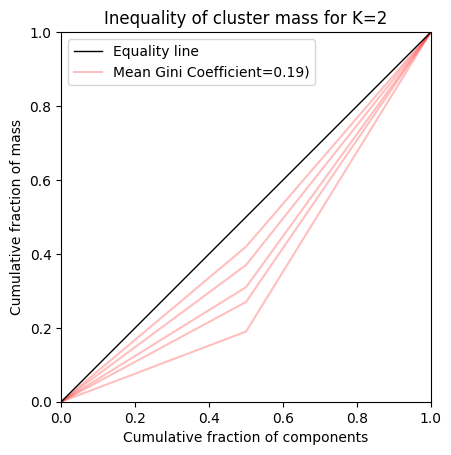

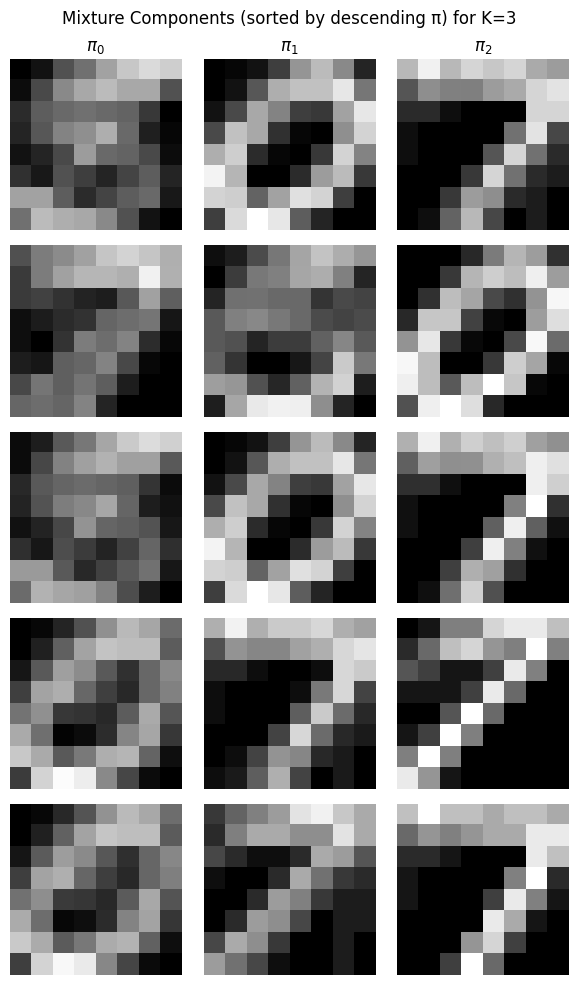

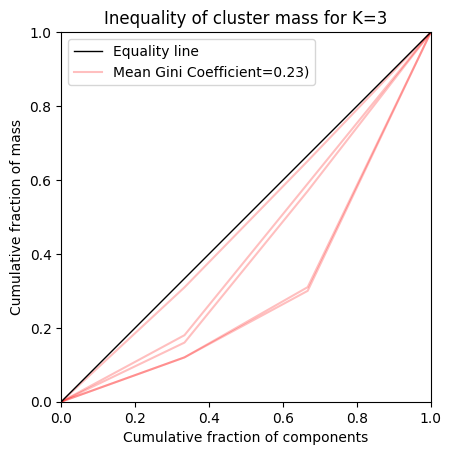

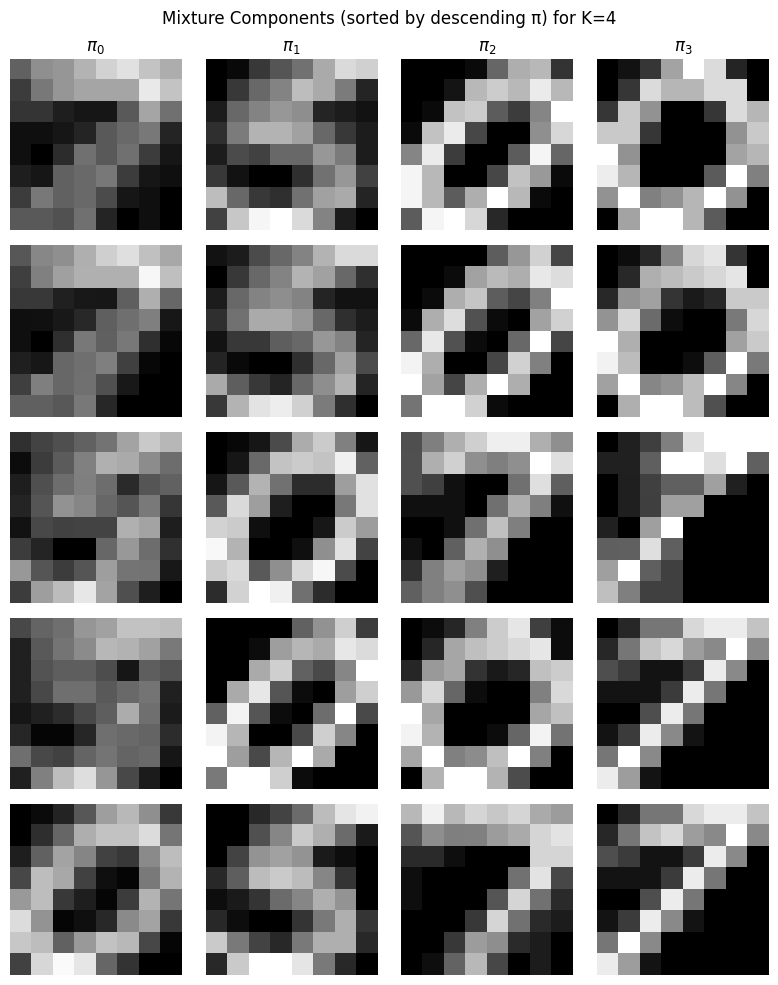

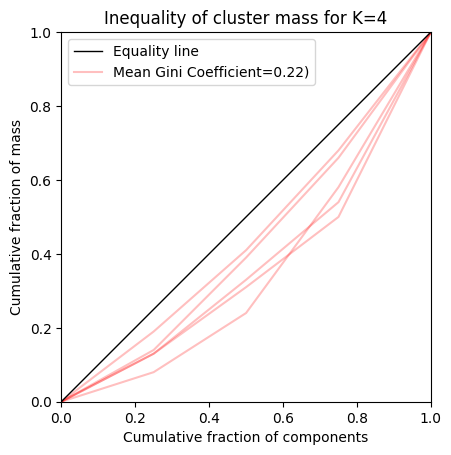

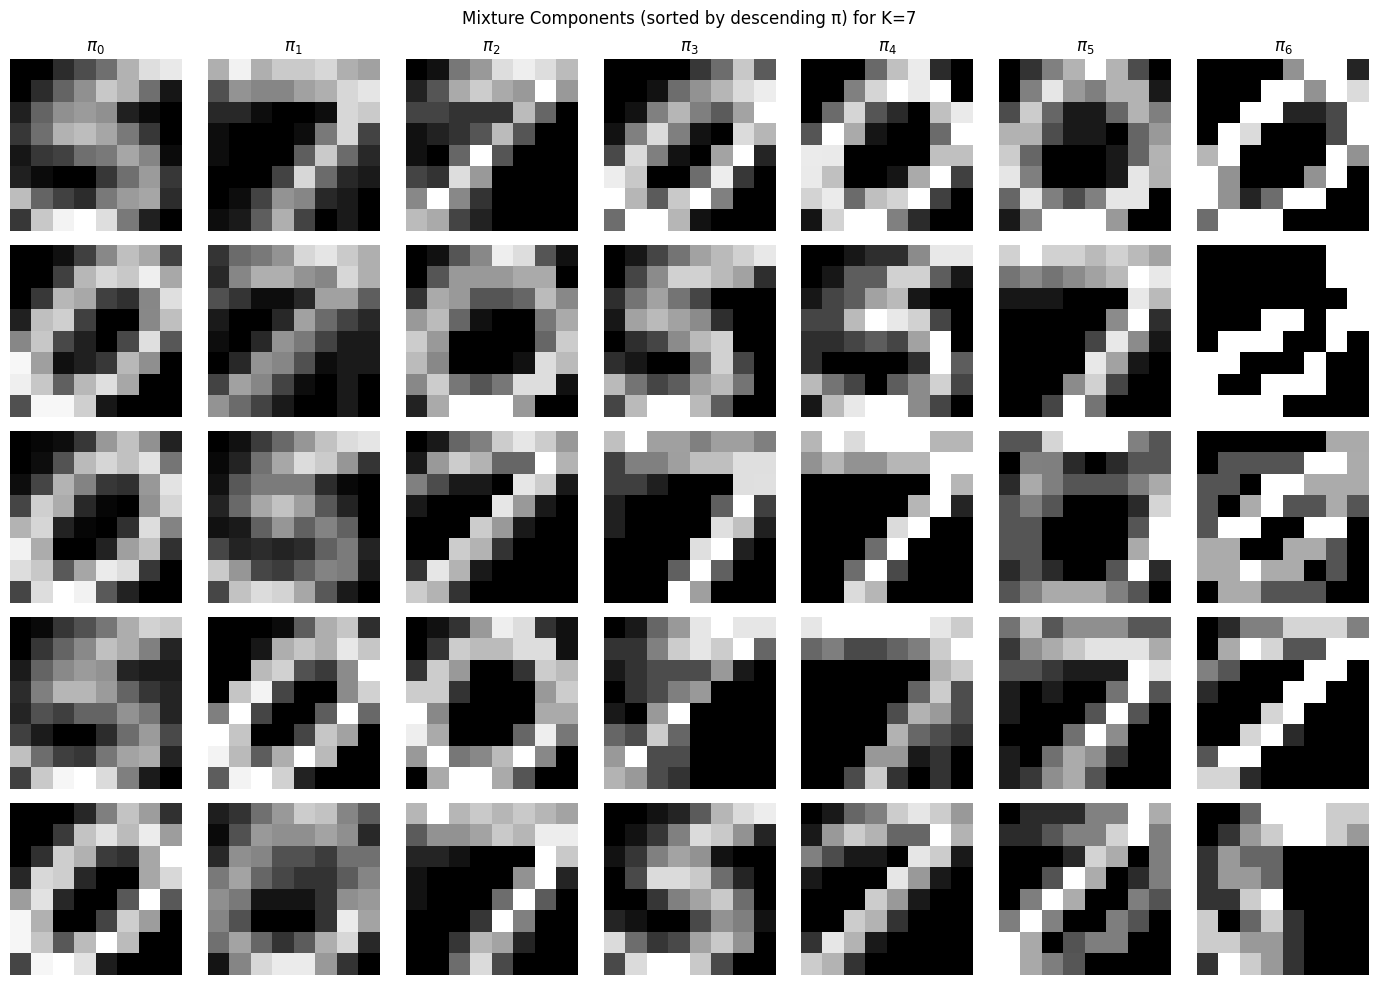

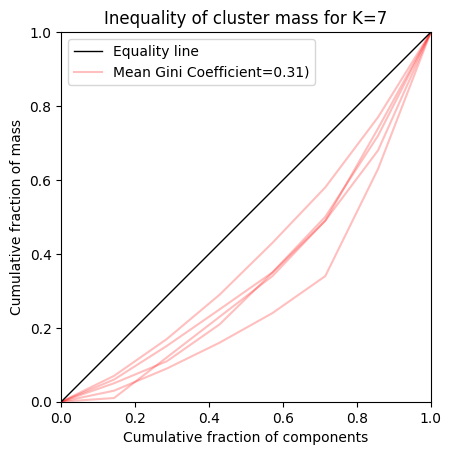

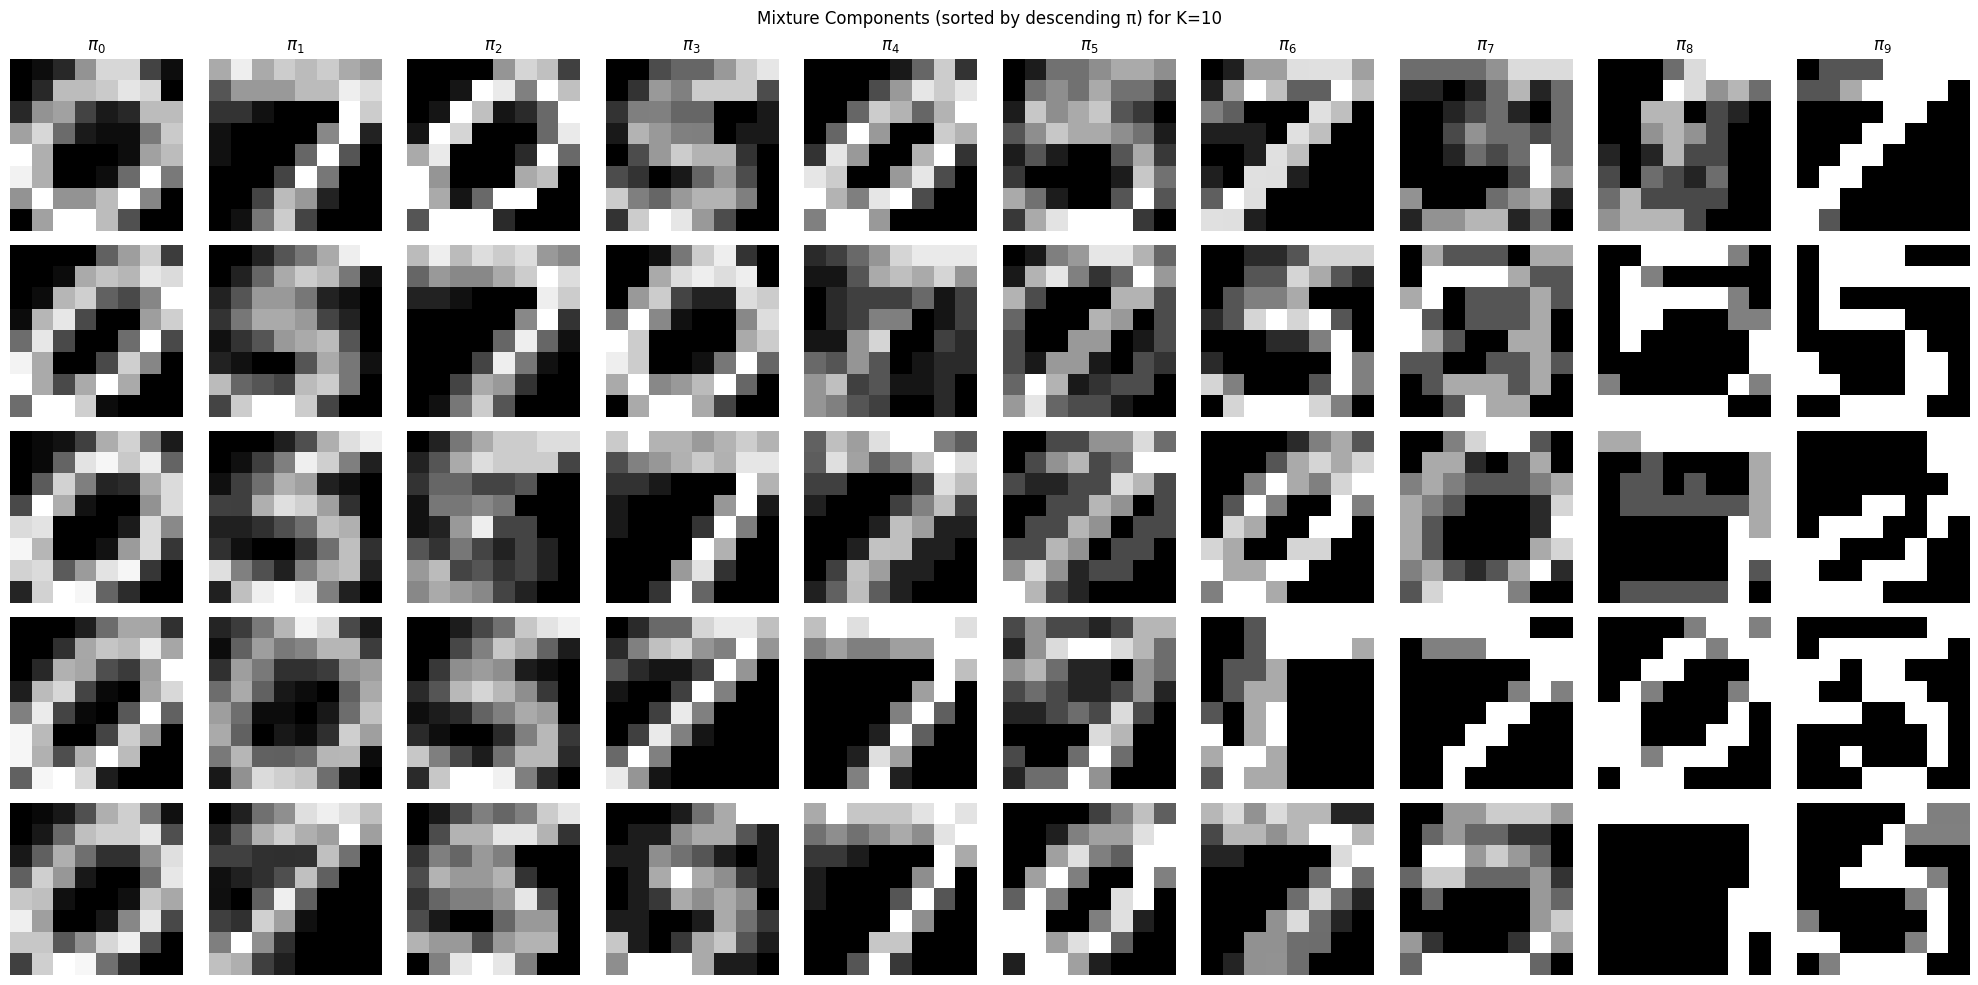

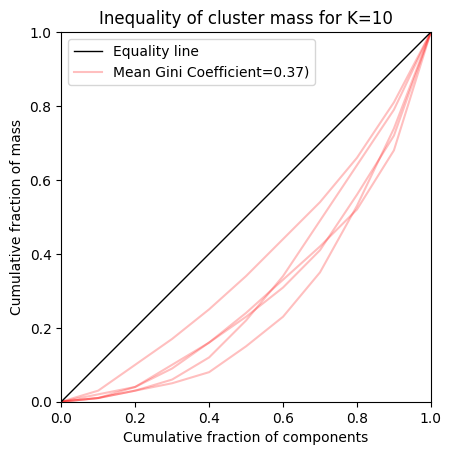

In [124]:
n_repeats = 5

for idxK, K in enumerate(mixtures):

    plt.figure(1 + idxK*3, figsize=(2*K, 2*n_repeats))

    mass_fractions = []

    for repeat in range(n_repeats):
        pi, P, r, ll, it, _ = em_run(K, data)

        # sort by π (descending) rearrange P and r
        order = np.argsort(-pi)
        pi = pi[order]
        P  = P[order, :]
        r  = r[:, order]

        mass = r.sum(axis=0)
        mass_fraction = mass / mass.sum()
        mass_fractions.append(mass_fraction)

        for k in range(K):
            idx = repeat*K + k + 1
            plt.subplot(n_repeats, K, idx)
            plt.imshow(P[k].reshape(8,8), cmap='gray', vmin=0, vmax=1, interpolation='nearest')
            if repeat == 0:
                plt.title(rf"$\pi_{k}$")
            plt.axis('off')

    plt.figure(1 + idxK*3)
    plt.suptitle(f"Mixture Components (sorted by descending π) for K={K}")
    plt.tight_layout()

    plt.figure(2 + idxK*3, figsize=(4.8, 4.8))

    # plot each repeat's Lorenz
    ginis = []
    for frac in mass_fractions:
        cum_frac = np.cumsum(frac[::-1]) # calculate cumulative fraction, need to reverse frac order to be ascending
        cum_frac = np.insert(cum_frac, 0, 0.0)      # prepend 0
        x = np.linspace(0, 1, len(cum_frac))         # cumulative fraction of clusters
        gini = 1.0 - 2.0 * np.trapezoid(cum_frac, x) # calculate gini coefficient
        ginis.append(gini)
        plt.plot(x, cum_frac, c='r', alpha=0.25)

    gini_mean = np.mean(ginis)

    plt.plot([0,1],[0,1],'-',c='k',lw=1, label='Equality line')
    plt.plot(0, 0, c='r', alpha=0.25, label=f"Mean Gini Coefficient={gini_mean:.2f})")

    plt.xlabel("Cumulative fraction of components")
    plt.ylabel("Cumulative fraction of mass")
    plt.title(f"Inequality of cluster mass for K={K}")
    plt.legend()
    plt.axis('square'); plt.xlim(0,1); plt.ylim(0,1)

In [ ]:
import gzip
from bitarray import bitarray
import pandas as pd

int_data = [int(x) for x in data.flatten()] # convert to integers
packed_data = bitarray(int_data) # pack data
g = gzip.compress(packed_data) # apply gzip

model_bits_float = [64*(x+64*x) for x in mixtures] # *64 for floats
total_bits_float = [sum(x) for x in zip(bits, model_bits_float)]
model_bits_optim = [4*(x+64*x) for x in mixtures]  # *4 for 4-bit
total_bits_optim = [sum(x) for x in zip(bits, model_bits_optim)]
bit_data = {'K': mixtures,
            'Data Bits':bits,
            'Model Bits (floats)':model_bits_float,
            'Total Bits (floats)':total_bits_float,
            'Model Bits (optim)':model_bits_optim,
            'Total Bits (optim)':total_bits_optim}
df = pd.DataFrame(bit_data)

print('Original size:', len(data.flatten()), 'bits')
print('After gzip compression:', len(g)*8, 'bits') # *8 to convert bytes-bits
print('Compression Bounds via Bernoulli Mixture Model:')
print(df.to_string(index=False))

Original size: 6400 bits
After gzip compression: 5416 bits
Compression Bounds via Bernoulli Mixture Model:
 K  Data Bits  Model Bits (floats)  Total Bits (floats)  Model Bits (optim)  Total Bits (optim)
 2       4767                 8320                13087                 520                5287
 3       4459                12480                16939                 780                5239
 4       4160                16640                20800                1040                5200
 7       3698                29120                32818                1820                5518
10       3312                41600                44912                2600                5912
